One ecommerce company has a project on predicting churned users in order to offer potential promotions.
An attached file is the dataset that is offered by the company (churn_predict.csv). You will using these dataset to answer below questions:


**1. What are the patterns/behavior of churned users? What are your suggestions to the company to reduce churned users. ***

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, silhouette_score

# Import and check data
df = pd.read_excel('data_source/churn_prediction.xlsx')
print(df.info())


```
<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   CustomerID                   5630 non-null   int64
 1   Churn                        5630 non-null   int64
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object
 4   CityTier                     5630 non-null   int64
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object
 7   Gender                       5630 non-null   object
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64
 10  PreferedOrderCat             5630 non-null   object
 11  SatisfactionScore            5630 non-null   int64
 12  MaritalStatus                5630 non-null   object
 13  NumberOfAddress              5630 non-null   int64
 14  Complain                     5630 non-null   int64
 15  OrderAmountHikeFromlastYear  5365 non-null   float64
 16  CouponUsed                   5374 non-null   float64
 17  OrderCount                   5372 non-null   float64
 18  DaySinceLastOrder            5323 non-null   float64
 19  CashbackAmount               5630 non-null   float64

dtypes: float64(8), int64(7), object(5)
memory usage: 879.8+ KB
None
```




In [ ]:
## EDA
# Remove missing and duplicated value
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)



```
<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 2 to 5363
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   CustomerID                   3774 non-null   int64
 1   Churn                        3774 non-null   int64
 2   Tenure                       3774 non-null   float64
 3   PreferredLoginDevice         3774 non-null   object
 4   CityTier                     3774 non-null   int64
 5   WarehouseToHome              3774 non-null   float64
 6   PreferredPaymentMode         3774 non-null   object
 7   Gender                       3774 non-null   object
 8   HourSpendOnApp               3774 non-null   float64
 9   NumberOfDeviceRegistered     3774 non-null   int64
 10  PreferedOrderCat             3774 non-null   object
 11  SatisfactionScore            3774 non-null   int64
 12  MaritalStatus                3774 non-null   object
 13  NumberOfAddress              3774 non-null   int64
 14  Complain                     3774 non-null   int64
 15  OrderAmountHikeFromlastYear  3774 non-null   float64
 16  CouponUsed                   3774 non-null   float64
 17  OrderCount                   3774 non-null   float64
 18  DaySinceLastOrder            3774 non-null   float64
 19  CashbackAmount               3774 non-null   float64
dtypes: float64(8), int64(7), object(5)
memory usage: 619.2+ KB
None

```



In [ ]:
# Outlier detection
columns_to_visualize = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                        'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'CashbackAmount']

for col in columns_to_visualize:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=df, y=col, color="skyblue")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

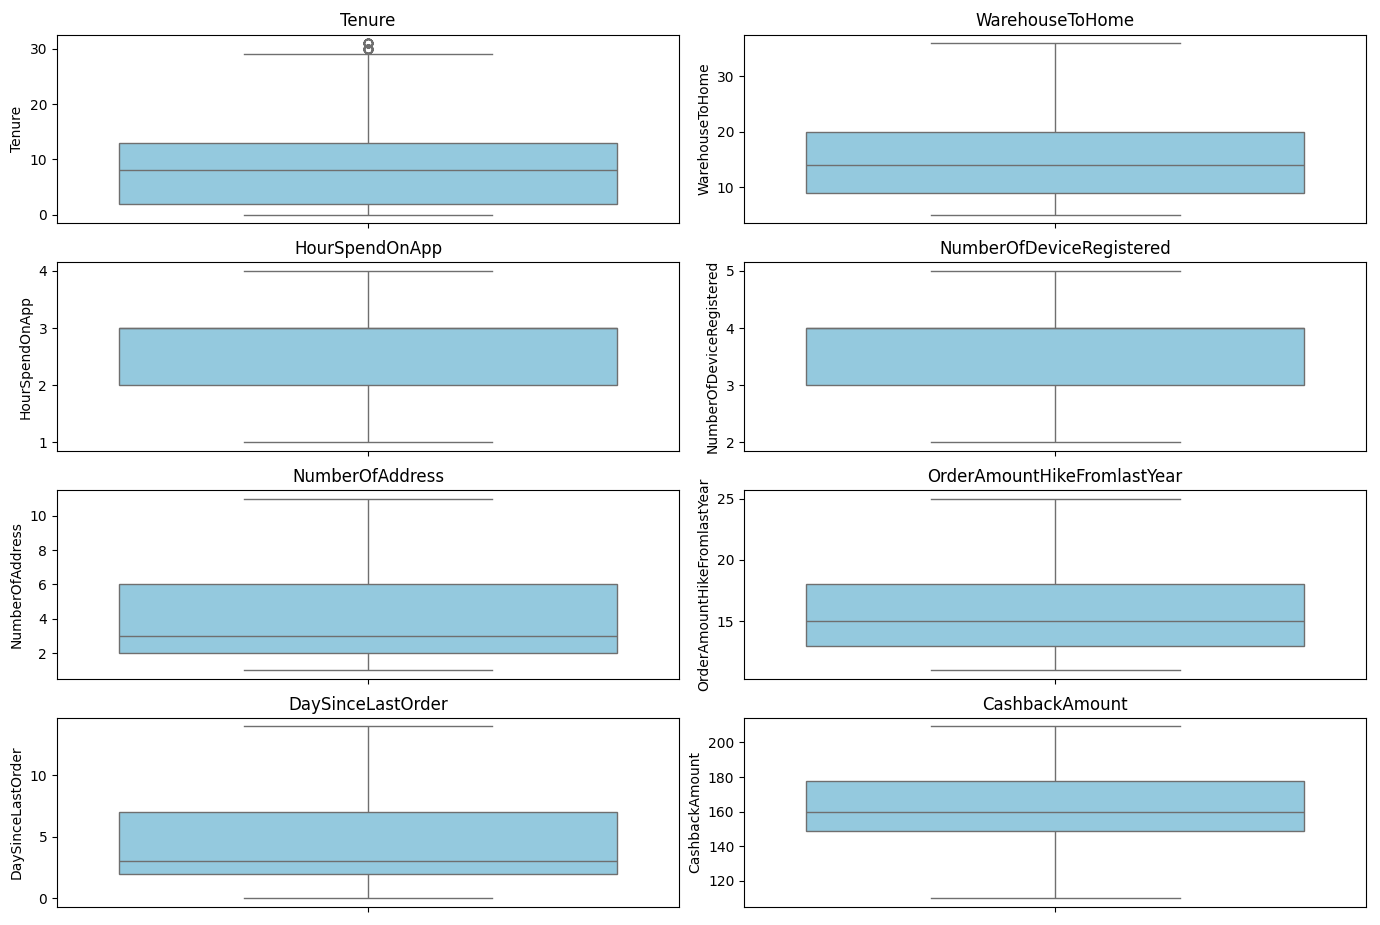

In [ ]:
## Transform Features
# Encoding categorical variables
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus', 'PreferedOrderCat']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Random Forest Model
# Prepare features and target
X = df.drop(['CustomerID', 'Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

## Feature important
importances = rf_model.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(6))
plt.title('Top 6 Feature Importances')
plt.show()

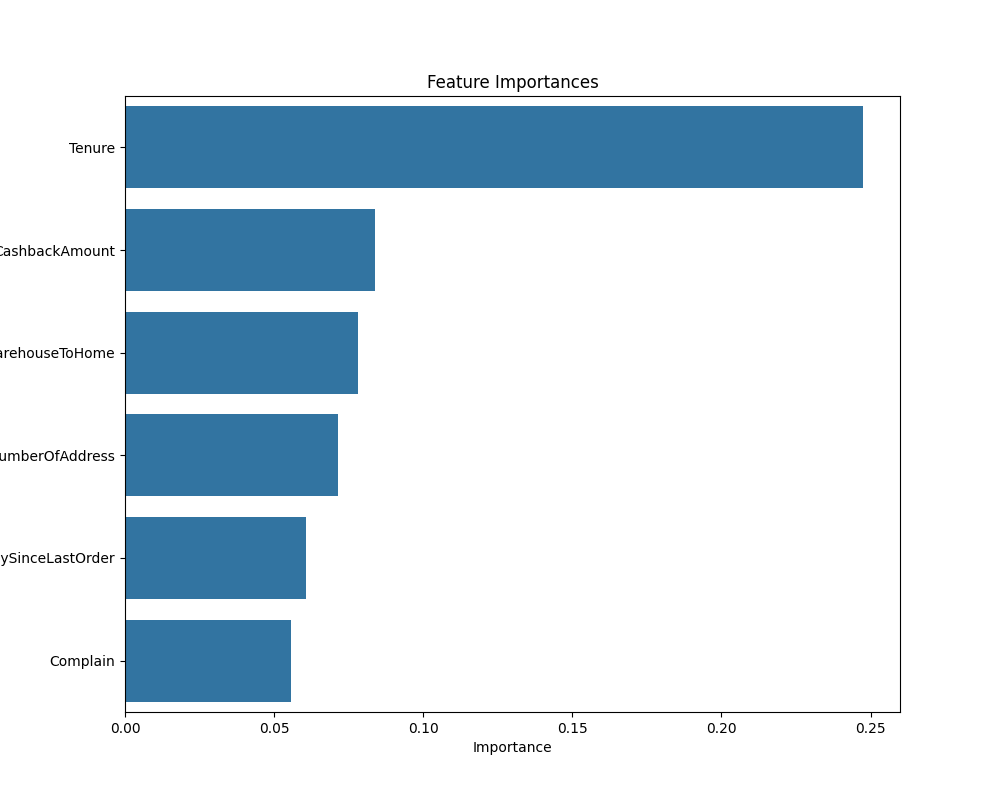

In [ ]:
# Analyze Top Features
top_6_features = ['Tenure', 'CashbackAmount', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'Complain']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, feature in enumerate(top_6_features):
    if feature == 'NumberOfAddress':
        # Categorical feature visualization using countplot
        sns.countplot(x=feature, hue='Churn', data=df, ax=axes[i], palette='coolwarm')
    else:
        # Numerical feature visualization using boxplot
        sns.boxplot(x='Churn', y=feature, data=df, ax=axes[i], palette='coolwarm')
if len(top_6_features) < len(axes):
        fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

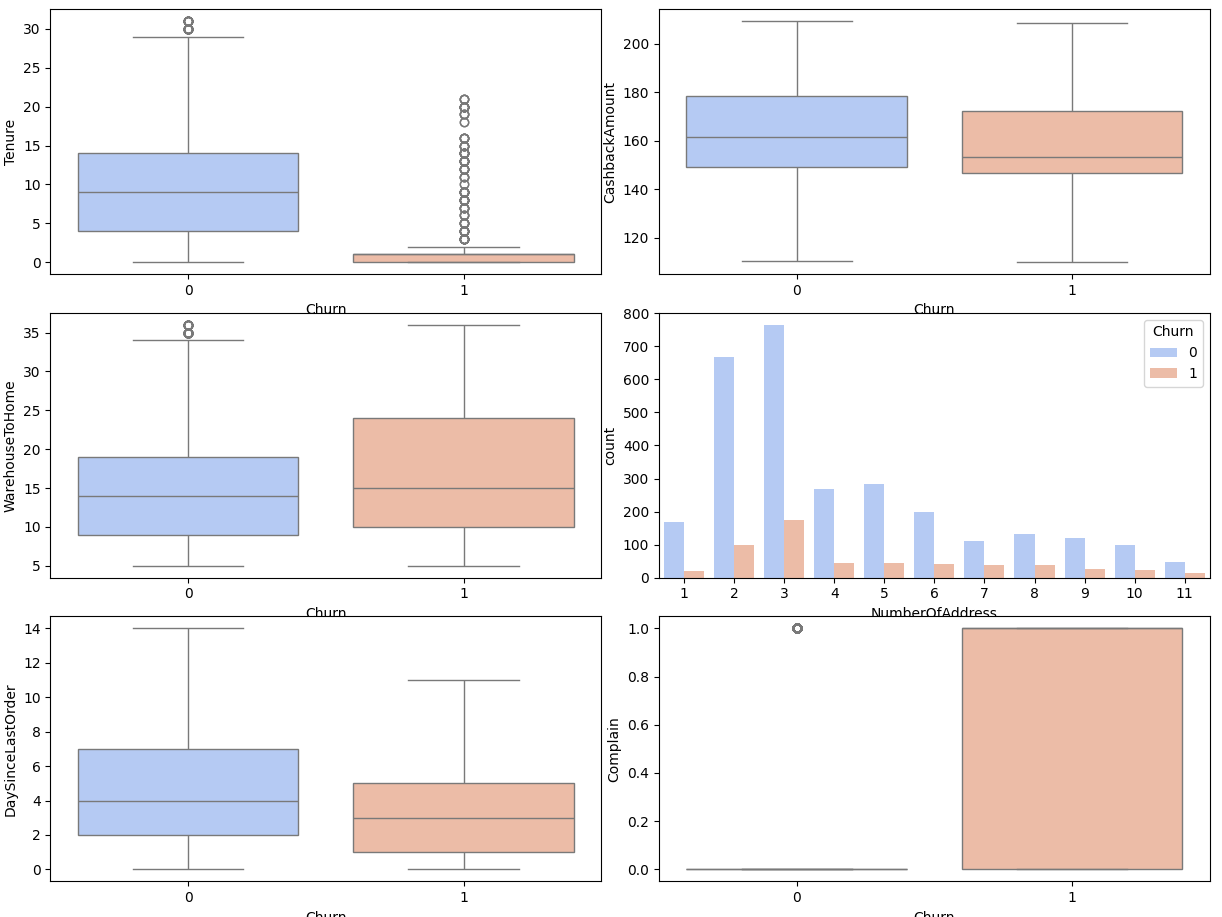



```
* Insight
  - Patterns: Churned users often have shorter tenures, live further from warehouses, register fewer addresses, and show longer inactivity periods. Complaints are a significant indicator of churn.
  - Recommendations:
    + Focus on improving early user retention strategies.
    + Enhance delivery logistics to improve the customer experience.
    + Address complaints effectively and engage inactive users with personalized campaigns.
```



**2. Build the Machine Learning model for predicting churned users. (fine tuning)**

In [ ]:
## Split data into feature, target, training, test
X = df.drop(columns=['Churn', 'CustomerID'])
y = df['Churn']
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure both train and test sets have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Normalize numerical feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Base random forest model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

# Fine tuning model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters and Model
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Predictions
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluation
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))

# Feature importances
feature_names = pd.get_dummies(X, drop_first=True).columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)



```
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Tuned Accuracy: 0.970873786407767
Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       944
           1       0.95      0.87      0.91       189

    accuracy                           0.97      1133
   macro avg       0.96      0.93      0.95      1133
weighted avg       0.97      0.97      0.97      1133

                                  Feature  Importance
0                                  Tenure    0.281231
2                         WarehouseToHome    0.088248
12                         CashbackAmount    0.083216
6                         NumberOfAddress    0.080954
11                      DaySinceLastOrder    0.074379
7                                Complain    0.062309
8             OrderAmountHikeFromlastYear    0.048720
5                       SatisfactionScore    0.045449
4                NumberOfDeviceRegistered    0.031255
10                             OrderCount    0.023692
9                              CouponUsed    0.019879
1                                CityTier    0.018363
28                   MaritalStatus_Single    0.016349
17       PreferredPaymentMode_Credit Card    0.015178
21                            Gender_Male    0.014893
23    PreferedOrderCat_Laptop & Accessory    0.014282
3                          HourSpendOnApp    0.013216
15               PreferredPaymentMode_COD    0.011032
13      PreferredLoginDevice_Mobile Phone    0.010130
18        PreferredPaymentMode_Debit Card    0.009416
19          PreferredPaymentMode_E wallet    0.008686
27                  MaritalStatus_Married    0.008512
25          PreferedOrderCat_Mobile Phone    0.006390
20               PreferredPaymentMode_UPI    0.006028
14             PreferredLoginDevice_Phone    0.004371
16  PreferredPaymentMode_Cash on Delivery    0.001900
24                PreferedOrderCat_Mobile    0.001449
26                PreferedOrderCat_Others    0.000472
22               PreferedOrderCat_Grocery    0.000000

```



 **3. Based on the behaviors of churned users, the company would like to offer some special promotions for them.
Please segment these churned users into groups. What are the differences between groups?**


In [ ]:
## Filter Churned Users
churned_users = df[df['Churn'] == 1].copy()

# Select relevant features
features = ['Tenure', 'CashbackAmount', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'Complain']

# Normalize features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
churned_users_scaled = scaler.fit_transform(churned_users[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
churned_users['Cluster'] = kmeans.fit_predict(churned_users_scaled)

# Evaluate Clustering
silhouette_avg = silhouette_score(churned_users_scaled, churned_users['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

## Apply Random Forest to Predict Clusters
X = churned_users[features]
y = churned_users['Cluster']
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

## Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title("Feature Importance for Cluster Prediction")
plt.show()

# Visualize Top Features for Each Cluster
top_features = feature_importances['Feature'].iloc[:3]  # Select top 3 features
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=churned_users, x='Cluster', y=feature)
    plt.title(f"Distribution of {feature} Across Clusters")
    plt.show()

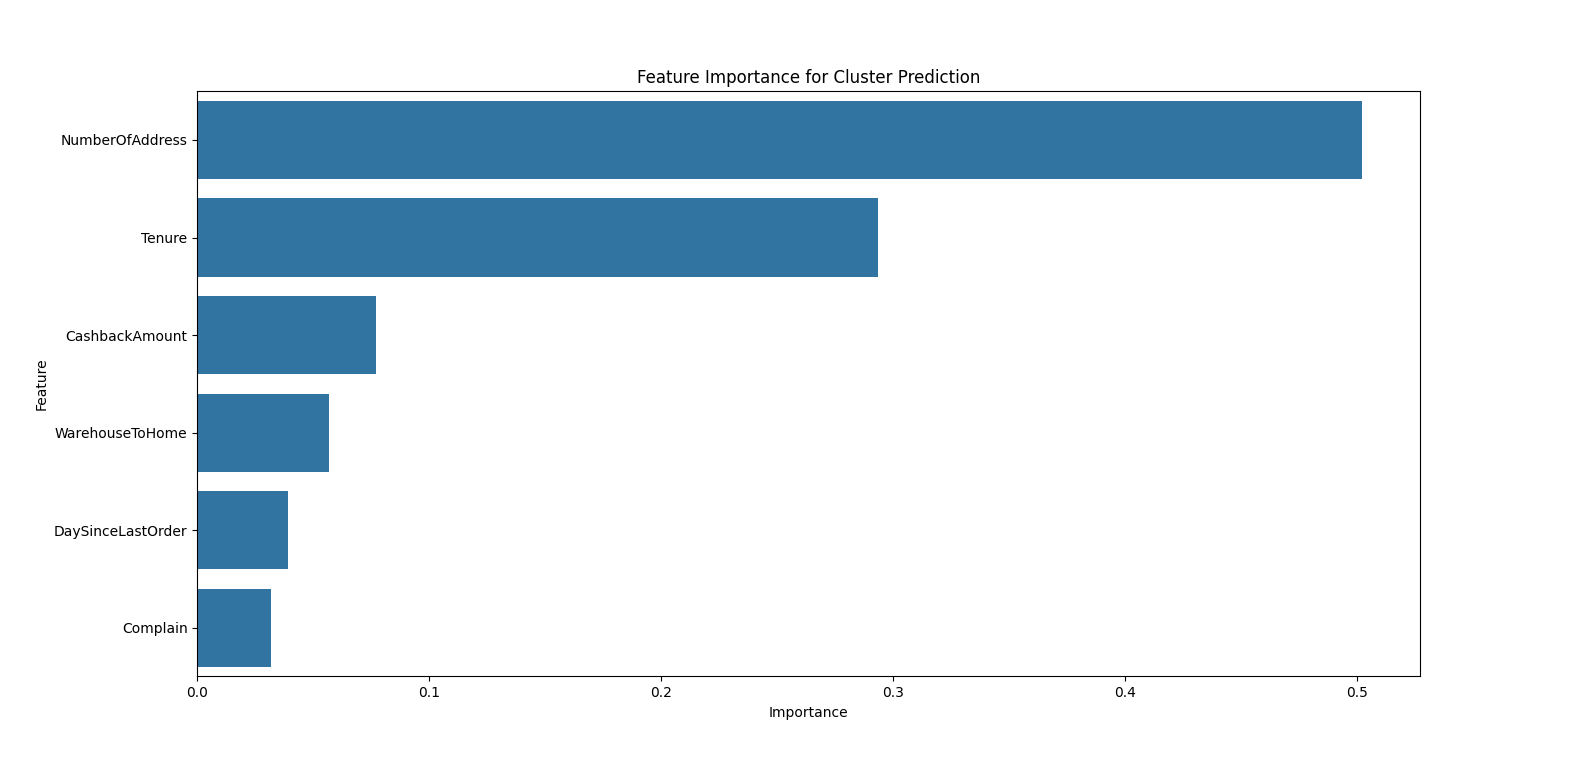

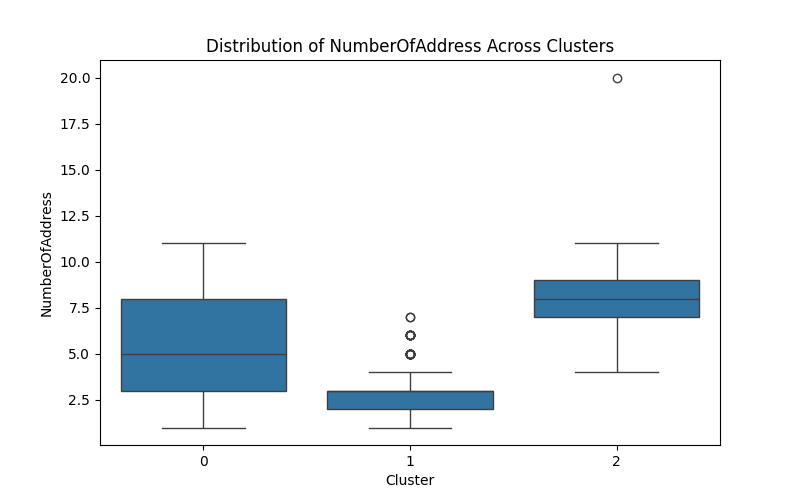

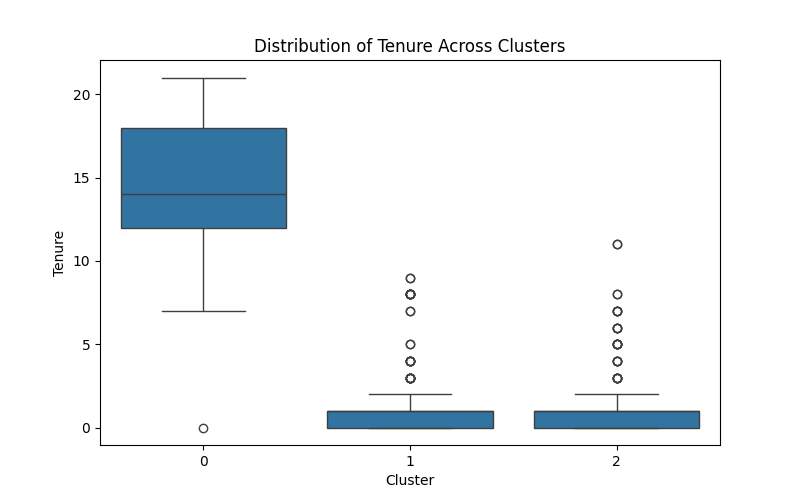



```
 * Differences between groups:
  - Cluster 0 represent a group that interacts with the service significantly more, characterized by higher tenures, a greater number of addresses, and higher cashback amounts.
  - Cluster 1 may represent new or less active participants, as suggested by the lowest medians across all features and the narrow ranges.
  - Cluster 2 is somewhat intermediate, reflecting moderate activity levels, with values between Clusters 0 and 1.
```

